In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
def t_poisson_batch(lam: float, T: int, N: int) -> list[np.ndarray]:
    """
    Generate event times for N Poisson processes up to time T with rate lam.

    Parameters:
    lam (float): Rate of the Poisson process.
    T (int): Maximum time.
    N (int): Number of Poisson processes to simulate.

    Returns:
    list[np.ndarray]: List of N arrays, each containing event times for one Poisson process.

    Example:
    --------
    >>> t_list_batch = t_poisson_batch(5, 10, 3)
    """

    max_events = int(T * lam)

    inter_arrival_times = np.random.exponential(1 / lam, size=(N, max_events))
    event_times = np.cumsum(inter_arrival_times, axis=1)
    t_lists = [np.insert(event_times[i, event_times[i] < T], 0, 0) for i in range(N)]

    return t_lists

In [3]:
def risk_process(
    u: float, c: float, T: int, h: float, lam: float, eta: float, N: int
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Simulate the risk process for multiple trajectories.

    Use Case:
    This function simulates the risk process for multiple trajectories, where each trajectory represents the evolution of reserves over time in an insurance-like scenario.

    Parameters:
    u (float): Initial capital or reserve.
    c (float): Claim arrival rate.
    T (int): Total time.
    h (float): Time step for discretization.
    lam (float): Rate of the Poisson process for claim arrivals.
    eta (float): Rate parameter of the exponential distribution for claim sizes.
    N (int): Number of trajectories to simulate.

    Returns:
    tuple[np.ndarray, np.ndarray, np.ndarray]: Array of risk reserve values and time arrays.

    Example:
    --------
    >>> R, t = risk_process(u=1.0, c=1.0, T=1000, h=1.0, lam=1.0, eta=1.0, N=100)
    """
    t = np.arange(0, T, h)
    R = np.zeros((N, len(t)))

    for i in range(N):
        p_times = t_poisson_batch(lam, T, 1)[0]
        num_poisson_events = len(p_times)

        if num_poisson_events == 0:
            R[i] = u + c * T
            continue

        x = np.random.exponential(1 / eta, size=num_poisson_events)

        claims = np.zeros_like(t)
        for j, ti in enumerate(t):
            claims[j] = np.sum(x[p_times <= ti])

        premiums = c * t

        R[i] = u + premiums - claims

    return R, t

In [4]:
def psi_estimate(
    u: float,
    T: int,
    h: float,
    lam: float,
    eta: float,
    N: int,
    c: float,
) -> float:
    """
    Estimate the probability of ruin at finite time T.

    Parameters:
    u (float): Initial capital or reserve.
    T (int): Total time.
    h (float): Time step for discretization.
    lam (float): Rate of the Poisson process for claim arrivals.
    eta (float): Rate parameter of the exponential distribution for claim sizes.
    N (int): Number of trajectories to simulate.
    c (float, optional): Claim arrival rate. Default is 1.0.


    Returns:
    float: Estimated probability of ruin at finite time T for the given parameters.
    Example:
    --------
    >>> psi_est=psi_estimate(u=1.0, c=1.0, T=1000, h=1.0, lam=1.0, eta=1.0, N=100)
    """

    R, _ = risk_process(u=u, c=c, T=T, h=h, lam=lam, eta=eta, N=N)

    ruins = np.any(R < 0, axis=1)

    return np.mean(ruins)

In [5]:
def psi_pc(u: float, c: float, lam: float, eta: float) -> float:
    """
    Estimate the probability of ruin at infinite time using Pollaczek-Chinczyn formula.

    Parameters:
    u (float): Initial capital or reserve.
    c (float): Claim arrival rate.
    lam (float): Rate of the Poisson process for claim arrivals.
    eta (float): Rate parameter of the exponential distribution for claim sizes.

    Returns:
    float: Estimated probability of ruin at infinite time.

    Example:
    --------
    >>> psi=psi_pc(u=1.0, c=1.0, lam=1.0, eta=1.0)
    """
    return (
        1
        if c <= lam * eta
        else ((eta * lam) * np.exp(-((1 / eta) - (lam / c)) * u)) / c
    )

In [6]:
def psi_inverse(u: float, psi: float, lam: float, eta: float) -> float:
    """
    Estimate the probability of c(psi,u) at infinite time using the inverse formula.

    Parameters:
    u (float): Initial capital or reserve.
    c (float): Claim arrival rate.
    lam (float): Rate of the Poisson process for claim arrivals.
    eta (float): Rate parameter of the exponential distribution for claim sizes.

    Returns:
    float: Estimated probability of c(u).

    Example:
    --------
    >>> psi_inv=psi_inverse(u=1.0, psi=0.5, lam=1.0, eta=1.0)
    """

    return (lam * u) / (scipy.special.lambertw((u * psi * np.exp(u / eta)) / eta).real)

In [ ]:
def c_estim_fpi(
    T: float,
    n: int,
    u_vector: np.ndarray,
    psi: float,
    initial_c: float = 1.0,
    lam: float = 1.0,
    eta: float = 1.0,
    max_iterations: int = 100,
    tolerance: float = 1e-6,
) -> np.ndarray:
    """
    Estimate the premium `c` using Fixed-Point Iteration (FPI) to achieve a target ruin probability `psi`.

    Parameters:
        T (float): Simulation time period.
        n (int): Number of Monte Carlo simulations for each case.
        u_vector (np.ndarray): Array of initial capital values `u` for which `c` is estimated.
        psi (float): Target probability of ruin.
        initial_c (float, optional): Initial guess for `c`. Defaults to 1.0.
        lam (float, optional): Intensity parameter of the Poisson process (average frequency of events). Defaults to 1.0.
        eta (float, optional): Mean claim size parameter. Defaults to 1.0.
        max_iterations (int, optional): Maximum number of iterations for FPI. Defaults to 100.
        tolerance (float, optional): Tolerance level for convergence. Defaults to 1e-6.

    Returns:
        np.ndarray: Estimated values of `c` for each `u` in `u_vector`.
    Example:
    --------
    >>> c_arr=c_estim_fpi(T=1000, n=100, u_vector=np.linspace(0, 10, 100), psi=0.5, initial_c=1.0, lam=1.0, eta=1.0, max_iterations=100, tolerance=1e-6
    """
    cs = np.zeros_like(u_vector)

    for i, u in enumerate(u_vector):
        c = initial_c

        for _ in range(max_iterations):
            psi_estimated = psi_estimate(eta=eta, u=u, h=1, c=c, T=T, lam=lam, N=n)

            if np.abs(psi_estimated - psi) < tolerance:
                break  # Convergence

            c = c + psi - psi_estimated

        cs[i] = c

    return cs

Symulacja N procesów ryzyka

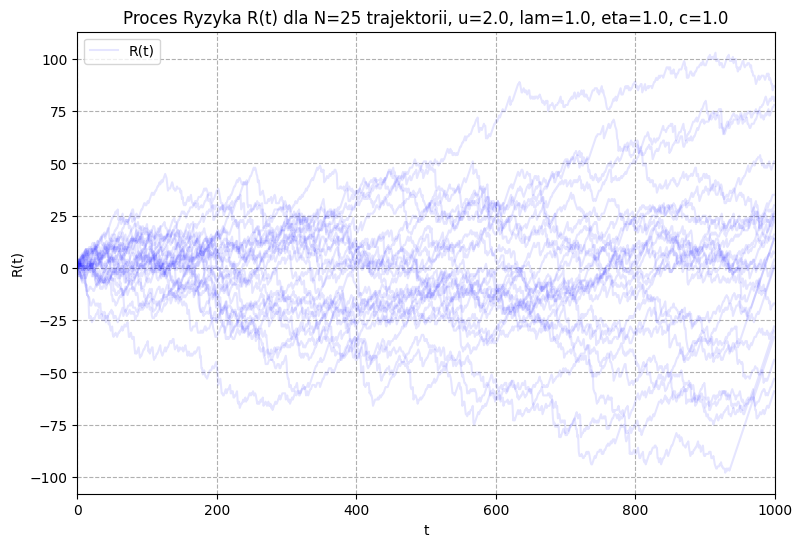

In [7]:
lam = 1.0
eta = 1.0
T = 1000
h = 1
u = 2.0
c = 1.0
N = 25
R, t = risk_process(u=u, T=T, h=h, lam=lam, eta=eta, N=N, c=c)
plt.figure(figsize=(9, 6))
for i in range(N):
    plt.plot(t, R[i], color="blue", alpha=0.1)
plt.xlabel("t")
plt.ylabel("R(t)")
plt.xlim(0, T)
plt.grid(True, linestyle="--")
plt.title(
    f"Proces Ryzyka R(t) dla N={N} trajektorii, u={u}, lam={lam}, eta={eta}, c={c}"
)
plt.legend(["R(t)"])
plt.show()

Estymacja prawdopodobieństwa ruiny w zależności od *u*, dla ustalonego c_0

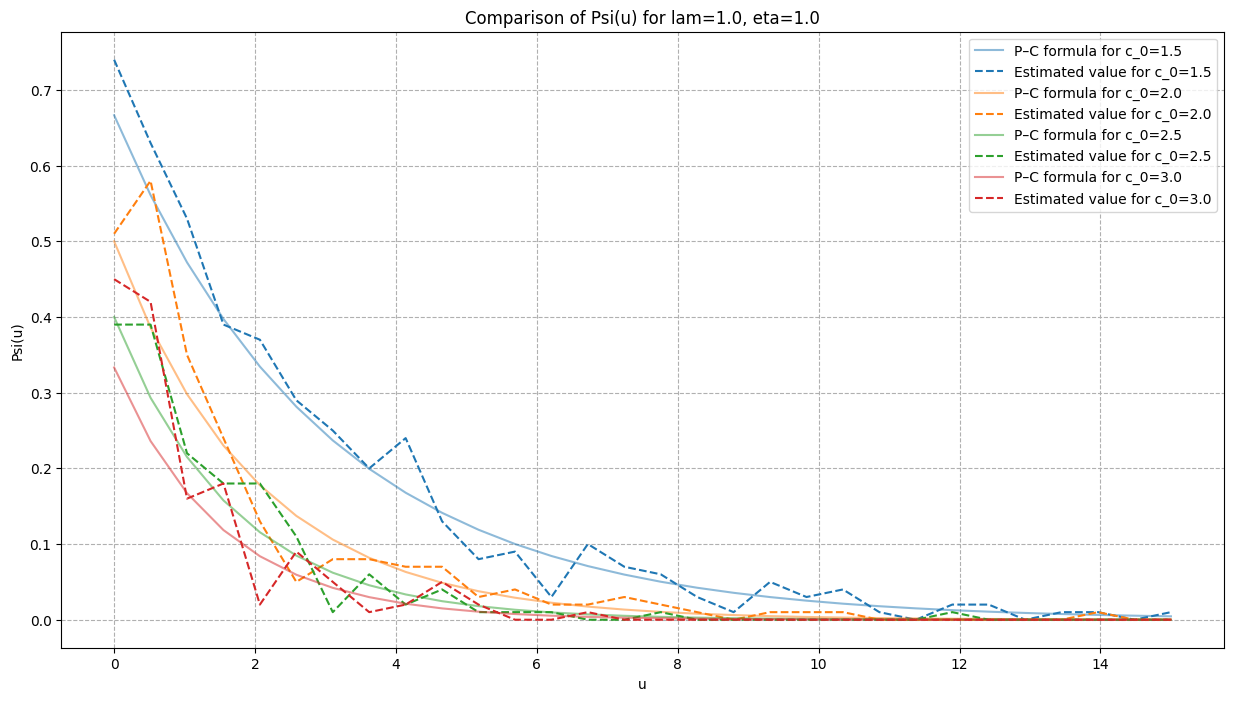

In [8]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plotted_labels = set()

u_values = np.linspace(0, 15, 30)
c_values = [1.5, 2.0, 2.5, 3.0]

plt.figure(figsize=(15, 8))
for j in range(len(c_values)):
    psi_u = []
    estimated_psi_u = []
    for i in range(len(u_values)):
        psi_u.append(psi_pc(u_values[i], c_values[j], lam, eta))
        estimated_psi_u.append(
            psi_estimate(
                u_values[i], c=c_values[j], T=1000, h=h, lam=lam, eta=eta, N=100
            )
        )
    plt.plot(
        u_values,
        psi_u,
        label=f"P–C formula for c_0={c_values[j]}",
        color=colors[j],
        alpha=0.5,
    )
    plt.plot(
        u_values,
        estimated_psi_u,
        label=f"Estimated value for c_0={c_values[j]}",
        linestyle="--",
        color=colors[j],
    )
plt.grid(True, linestyle="--")
plt.xlabel("u")
plt.ylabel("Psi(u)")
plt.title(f"Comparison of Psi(u) for lam={lam}, eta={eta}")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(
    by_label.values(),
    by_label.keys(),
    loc="upper right",
)
plt.show()

Estymacja prawdopodobieństwa ruiny w zależności od *c*, dla ustalonego u_0

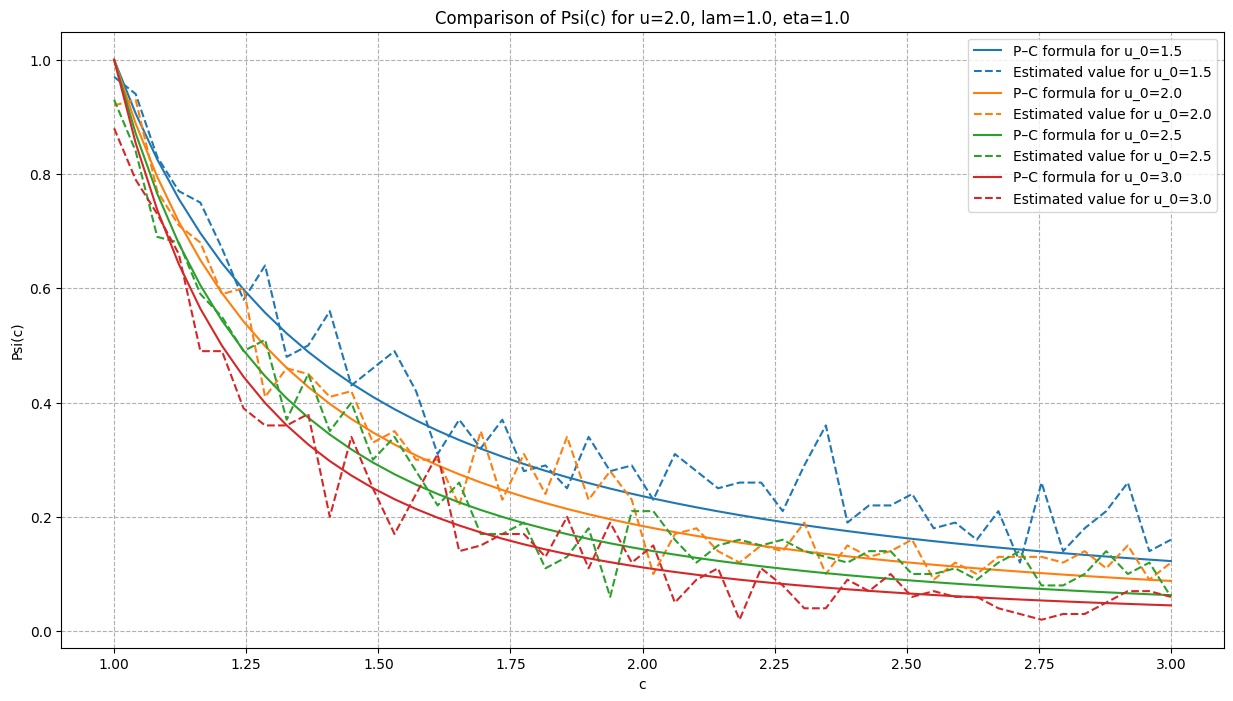

In [9]:
c_values = np.linspace(1, 3, 50)
u_values = [1.5, 2.0, 2.5, 3.0]
plt.figure(figsize=(15, 8))
for j in range(len(u_values)):
    psi_c = []
    estimated_psi_c = []
    for i in range(len(c_values)):
        psi_c.append(psi_pc(u=u_values[j], c=c_values[i], lam=lam, eta=eta))
        estimated_psi_c.append(
            psi_estimate(
                u=u_values[j], c=c_values[i], T=1000, h=h, lam=lam, eta=eta, N=100
            )
        )
    plt.plot(
        c_values, psi_c, label=f"P–C formula for u_0={u_values[j]}", color=colors[j]
    )
    plt.plot(
        c_values,
        estimated_psi_c,
        label=f"Estimated value for u_0={u_values[j]}",
        color=colors[j],
        linestyle="--",
    )

plt.grid(True, linestyle="--")
plt.xlabel("c")
plt.ylabel("Psi(c)")
plt.title(f"Comparison of Psi(c) for u={u}, lam={lam}, eta={eta}")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(
    by_label.values(),
    by_label.keys(),
    loc="upper right",
)

plt.show()

Funkcja odwrotna w zależności od u, dla ustalonego psi_0

C:\Users\julia\AppData\Local\Temp\ipykernel_78228\2659277836.py:19: RuntimeWarning: invalid value encountered in scalar divide
  return (lam * u) / (scipy.special.lambertw((u * psi * np.exp(u / eta)) / eta).real)


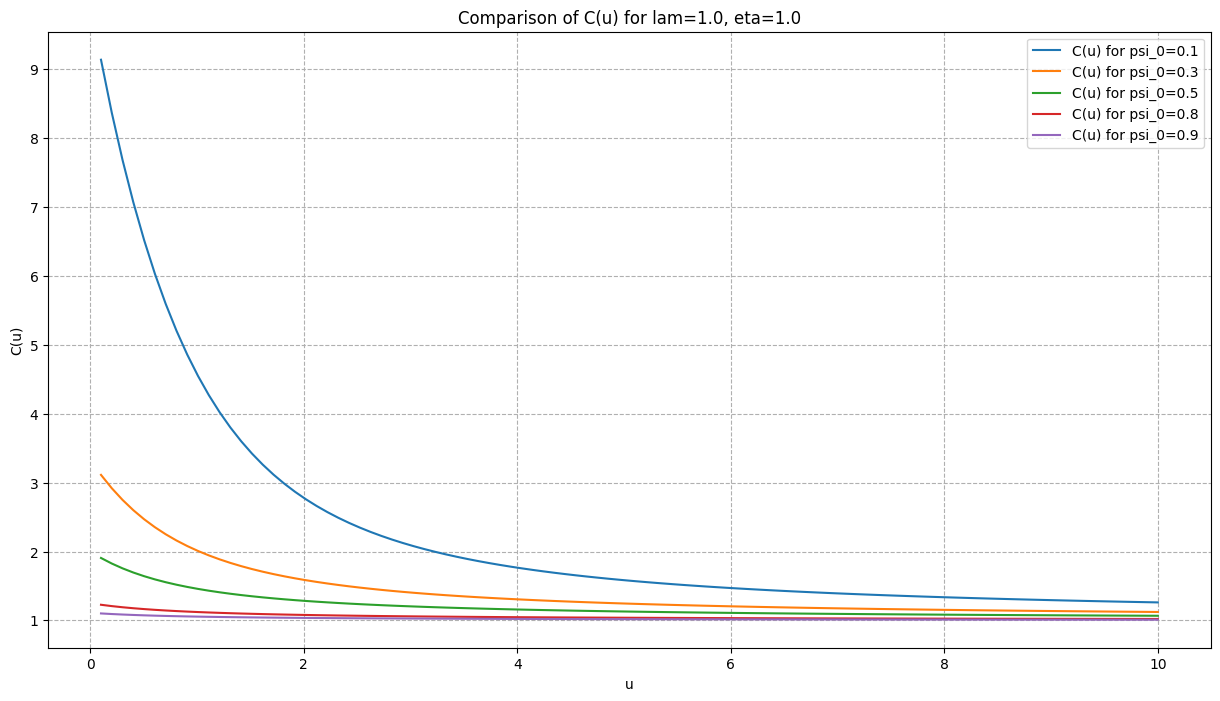

In [22]:
u_values = np.linspace(0, 10, 100)
psi_values = [0.1, 0.3, 0.5, 0.8, 0.9]


plt.figure(figsize=(15, 8))
for j in range(len(psi_values)):
    estimated_c = []
    for i in range(len(u_values)):
        estimated_c.append(
            psi_inverse(u=u_values[i], psi=psi_values[j], lam=lam, eta=eta)
        )
    plt.plot(u_values, estimated_c, label=f"C(u) for psi_0={psi_values[j]}")
plt.grid(True, linestyle="--")
plt.xlabel("u")
plt.ylabel("C(u)")
plt.title(f"Comparison of C(u) for lam={lam}, eta={eta}")
plt.legend()
plt.show()

In [31]:
u_values = np.linspace(0, 10, 100)
psi_values = [0.1, 0.3, 0.5, 0.8, 0.9]


plt.figure(figsize=(15, 8))
for j in range(len(psi_values)):
    estimated_c = []
    for i in range(len(u_values)):
        estimated_c.append(
            psi_inverse(u=u_values[i], psi=psi_values[j], lam=lam, eta=eta)
        )
    c_estimated = c_estim_fpi(
        T=1000,
        n=50,
        u_vector=u_values,
        psi=psi_values[j],
        initial_c=0.5,
        lambd=lam,
        eta=eta,
    )
    plt.plot(
        u_values,
        c_estimated,
        label=f"C estimated for psi_0={psi_values[j]}",
        color=colors[j],
        linestyle="--",
    )
    plt.plot(
        u_values, estimated_c, label=f"C(u) for psi_0={psi_values[j]}", color=colors[j]
    )
plt.grid(True, linestyle="--")
plt.xlabel("u")
plt.ylabel("C(u)")
plt.title(f"Comparison of C(u) for lam={lam}, eta={eta}")
plt.legend()
plt.show()

C:\Users\julia\AppData\Local\Temp\ipykernel_78228\2659277836.py:19: RuntimeWarning: invalid value encountered in scalar divide
  return (lam * u) / (scipy.special.lambertw((u * psi * np.exp(u / eta)) / eta).real)
